Курсовая работа по теории вероятностей и математической статистике

Проверка гипотезы о нормальном распределении логарифмической
доходности по критерию Шапиро-Франчиа

Вид исследуемых данных:

Котировки акций компаний, входящих в индекс МосБиржи голубых фишек (MOEXBC)

Мамаджанов Азиз

In [1]:
from scipy.stats import kstest
from statsmodels.distributions.empirical_distribution import ECDF

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

Количество торговых дней

In [2]:
def company_tables(single_ticker: str) -> pd.DataFrame:
    '''
    Чтение файлов
    '''
    ticker_file = pd.read_csv(f'{single_ticker}.csv', sep=',') 
    ticker_file['Date'] = pd.to_datetime(ticker_file['Date'], dayfirst=1,infer_datetime_format=1) 
    return ticker_file


def t_d_table(tickers_list: list) -> pd.DataFrame:
    '''
    Создание таблицы с временными промежутоками для каждого тикера
    '''
    trading_days_list = [] 
    for el in tickers_list:
        trading_days_list.append(company_tables(el).groupby(company_tables(el)['Date'].dt.year)['Date'].count())
    year_dict = dict.fromkeys(list(company_tables(el)['Date'].dt.year.unique()))
    
    for i in year_dict.keys():
        year_dict[i] = tuple(trading_days_list[el_td][i] for el_td in range(len(trading_days_list)))
    return pd.DataFrame(year_dict, index=tickers_list)


st_td1 = time.time()
user_companies = "GAZP SBER LKOH YNDX GMKN NVTK ROSN POLY PLZL MGNT TATN SNGS ALRS NLMK".split()
t_d_table(user_companies).to_csv(f'Количество торговых дней.csv')

st_td2 = time.time()
print(st_td2 - st_td1)

0.3658452033996582


Аномальные скачки

2.087270498275757


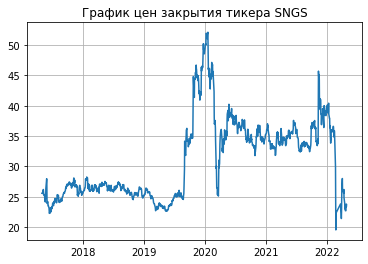

In [3]:
dev_time1 = time.time()

def max_deviation(ticker_year: int, ticker_file) -> float:
    '''
    Нахождение максимального отклонения по годам
    '''
    ticker_df = pd.read_csv(ticker_file, sep=",")
    date_values = list()
    for i in range(len(ticker_df['Date'])):
        date_values.append(int(str(ticker_df['Date'][i])[:4]))
    ticker_df['Date'] = date_values
    
    indexes = tuple(np.where(ticker_df['Date'] == ticker_year)[0])[:-1]
    percents = tuple(round(ticker_df['Close'][el + 1] / ticker_df['Close'][el] * 100 - 100, 2) for el in indexes)
    return max(percents)


years_company = range(2017, 2022)
tickers_dfMax = pd.DataFrame() 
tickers_dfMax['Ticker'] = user_companies

for el in years_company: 
    max_deviation_list = []
    for i in user_companies:
        max_deviation_list.append(max_deviation(el, f'{i}.csv'))
    tickers_dfMax[str(el)] = max_deviation_list
    
dev_time2 = time.time()
print(dev_time2 - dev_time1)

tickers_dfMax.to_csv(f'Скачки вверх.csv')

def min_deviation(ticker_year: int, ticker_file) -> float:
    '''
    Нахождение минимального отклонения по годам
    '''
    ticker_df = pd.read_csv(ticker_file, sep=",")
    date_values = list()
    for i in range(len(ticker_df['Date'])):
        date_values.append(int(str(ticker_df['Date'][i])[:4]))
    ticker_df['Date'] = date_values
    indexes = tuple(np.where(ticker_df['Date'] == ticker_year)[0])[:-1]
    percents = tuple(round(ticker_df['Close'][i + 1] / ticker_df['Close'][i] * 100 - 100, 2) for i in indexes)
    return min(percents)

tickers_dfMin = pd.DataFrame() 
tickers_dfMin['Ticker'] = user_companies

for el in years_company: 
    min_deviation_list = []
    for i in user_companies:
        min_deviation_list.append(min_deviation(el, f'{i}.csv'))
    tickers_dfMin[str(el)] = min_deviation_list

tickers_dfMin.to_csv(f'Скачки вниз.csv')

SNGS = company_tables('SNGS')
plt.plot(SNGS['Date'], SNGS['Adj Close'])
plt.title(f'График цен закрытия тикера SNGS')
plt.grid(True)
plt.show()

Процентили нормального распределния

In [4]:
start_ppfn = time.time()

data = []
quantiles_list = range(0, 101, 5)
for el in quantiles_list:
    data.append([el / 100, sts.norm.ppf(el / 100)])
 
percentiles_df = pd.DataFrame(data, columns=['Персентиль', 'Значение'])
end_ppfn = time.time()
print(end_ppfn - start_ppfn)
percentiles_df

0.010000467300415039


,Персентиль,Значение
0,0.00,-inf
1,0.05,-1.644854
2,0.10,-1.281552
3,0.15,-1.036433
4,0.20,-0.841621
5,0.25,-0.674490
6,0.30,-0.524401
7,0.35,-0.385320
8,0.40,-0.253347
9,0.45,-0.125661


Таблица квантилей

In [5]:
def shapiro_francia_st(company_list: list) -> float:
    '''
    Релизация статистики Шапиро - Франчиа
    '''
    company_list = sorted(company_list)
    company_size, list_mean = len(company_list), np.mean(company_list)
    x2 = np.sum(pow(company_list - list_mean, 2))
    m = np.zeros(company_size)
    for el in range(1, company_size + 1):
        m[el - 1] = 4.91 * (((el - 0.375) / (company_size + 0.25)) ** 0.14 -
                 ((company_size - el + 0.625) / (company_size + 0.25)) ** 0.14)
    
    shapiro_francia1 = pow(np.sum(m * company_list), 2)
    shapiro_francia2 = x2 * np.sum(pow(m, 2))
    shapiro_francia = shapiro_francia1 / shapiro_francia2
    return shapiro_francia

shapiro_franciat1= time.time() 
trials = 1000 
sample_size = 258 

normal_values = []
for el in range(trials):
    x = np.random.normal(size=sample_size) 
    normal_values.append(shapiro_francia_st(x)) 
    
q_array = tuple(np.arange(0.001, 1.001, 0.01))
quantiles_list = pd.DataFrame(normal_values, columns=['Квантили']).quantile(q_array)
quantiles_list.to_csv(f"Таблица квантилей.csv") 

shapiro_franciat2= time.time() 
print(shapiro_franciat2 - shapiro_franciat1) 

quantiles_list

0.6341395378112793


,Квантили
0.001,0.976962
0.011,0.985778
0.021,0.987225
0.031,0.988179
0.041,0.988811
...,...
0.951,0.997663
0.961,0.997749
0.971,0.997834
0.981,0.997968


KstestResult(statistic=0.034363029575462445, pvalue=0.18410026732229312)
Альтернативная гипотеза в Колмогорове, она же в основном тесте с вер. 90%
2.463144540786743


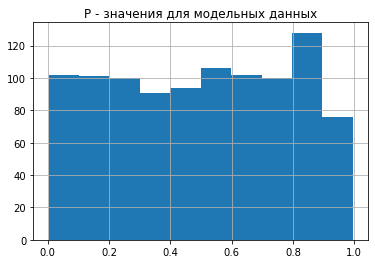

In [6]:
def p_values(company_value: float) -> float:
    '''
    Расчет p-значения
    '''
    pv_w0 = shapiro_francia_st(np.random.normal(loc=0, scale=1, size=company_value)) 
    pv_mu = -1.2725 + 1.0521 * (np.log(np.log(company_value)) - np.log(company_value))
    pv_sigma = -0.26758 * (np.log(np.log(company_value)) + 2 / np.log(company_value)) + 1.0308
    p_value = 1 - sts.norm(loc=0, scale=1).cdf((np.log(1 - pv_w0) - pv_mu) / pv_sigma)
    return p_value

model_pt1 = time.time() 

pval_array = np.zeros(trials) 
for el in range(0, trials):
    pval_array[el] = p_values(sample_size)
    
plt.hist(pval_array) 
plt.title("P - значения для модельных данных")
plt.grid(True) 

kolmogorov_t = kstest(pval_array,'uniform') 

if pval_array[1] < 0.01:
    print(kolmogorov_t)
    print('Альтернативная гипотеза в Колмогорове, она же в основном тесте с вер. 99%')
if 0.01 <= pval_array[1] < 0.05:
    print(kolmogorov_t)
    print('Альтернативная гипотеза в Колмогорове, она же в основном тесте с вер. 95%')
if 0.05 <= pval_array[1] < 0.1:
    print(kolmogorov_t, )
    print('Альтернативная гипотеза в Колмогорове, она же в основном тесте с вер. 90%')
if pval_array[1] > 0.1:
    print(kolmogorov_t)
    print('Основаая гипотеза в Колмогорове, она же в основном тесте')

model_pt2 = time.time() 
print(model_pt2 - model_pt1) 

Мощность критерия

In [7]:
powert1 = time.time()

pw_list = []
for el in range(trials):
    pw_list.append(shapiro_francia_st(np.random.standard_t(4, size=sample_size)))

p_list = [p_values(sample_size) for i in range(trials)]    

ecdf_power = ECDF(p_list)
# создадим словарь со значением мощности при 0.5% и 0.1%
power_dict = {0.05: ecdf_power(0.005),
              0.01: ecdf_power(0.01)}
print(*power_dict.items())

powert2 = time.time()
print(powert2 - powert1) 

(0.05, 0.003) (0.01, 0.009000000000000001)
2.916069746017456


Реальные р - значения

In [8]:
def log_return(moex_ticker: str, x: int) -> list:
    '''
    Расчет логдоходности
    '''
    log_return_list, company = list(), company_tables(moex_ticker)
    company['Логдоходность'] = np.log(company['Adj Close'])
    for year in list(company['Date'].dt.year.unique()):
        t_d_file = pd.read_csv(f'Количество торговых дней.csv', sep=',')
        num = (t_d_file[str(year)][x])
        z = company['Логдоходность'][company['Date'] <= str(year) +'-12-31'].size - (num + 1)
        log_return_list.append((company['Логдоходность'][company['Date'] <= str(year) + '-12-31'])[z:].kurtosis())
    return log_return_list 


def sf_prices(moex_ticker: str) -> list:
    criteria_prices, company = list(), company_tables(moex_ticker)
    for year in list(company['Date'].dt.year.unique()):
        criteria_prices.append(shapiro_francia_st(company['Adj Close'][company['Date'] <= str(year) + '-12-31']))
    return criteria_prices



KstestResult(statistic=0.034363029575462445, pvalue=0.18410026732229312)
Альтернативная гипотеза в Колмогорове, она же тесте с вер. 90%
0.9478299617767334


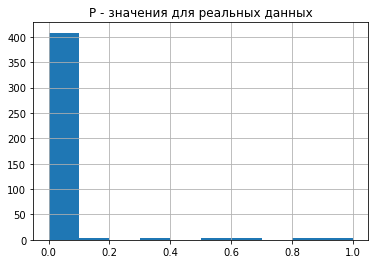

In [9]:
def real_pvalues(logreturn, shapiro_francia):
    '''Расчет p значений для реальных данных'''
    p_real_list = []
    for el in logreturn:
        el1 = 0
        for el2 in shapiro_francia:
            if el > el2:
               el1 += 1
            p_real_list.append(round(el1 / len(shapiro_francia), 3))
    return p_real_list


real_p_t1 = time.time() 
user_companies = "GAZP SBER LKOH GMKN NVTK ROSN POLY PLZL MGNT TATN ALRS NLMK".split()

PV_for_companies = []
for i in user_companies:
    log, sh = log_return(i, user_companies.index(i)), sf_prices(i)
    for el in real_pvalues(log, sh):
        PV_for_companies.append(el)
        
plt.hist(PV_for_companies)
plt.title("P - значения для реальных данных")
plt.grid(True)

if pval_array[1] < 0.01:
    print(kolmogorov_t)
    print('Альтернативная гипотеза в Колмогорове, она же в основном тесте с вер. 99%')
if 0.01 <= pval_array[1] < 0.05:
    print(kolmogorov_t)
    print('Альтернативная гипотеза в Колмогорове, она же в основном тесте с вер. 95%')
if 0.05 <= pval_array[1] < 0.1:
    print(kolmogorov_t)
    print('Альтернативная гипотеза в Колмогорове, она же тесте с вер. 90%')
if pval_array[1] > 0.1:
    print(kolmogorov_t)
    print('Основная гипотеза в Колмогорове, она же в основном тесте')

real_p_t2 = time.time() 
print(real_p_t2 - real_p_t1)